# 























































































Mean Maps


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colorbar import Colorbar
from pykrige.ok import OrdinaryKriging
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from matplotlib.patches import FancyArrow
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from shapely.geometry import box
from PIL import Image
import warnings
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

In [30]:
general_path = 'C:/Users/Windows/OneDrive/Documentos/mestrado/DISSERTAÇÃO/scripts'
plt.rcParams.update({'font.family': 'Times New Roman'})
# Definindo os parâmetros
years = list(range(2014, 2025))
letra = list("abcdefghijklmnopqrstuvwxyz")
mapas =['EI_30', 'rain', 'E_D']
unity = ['Erosividade (MJ.mm/ha.h.ano)', 'Chuva anual (mm/ano)', 'Densidade de erosividade (MJ/ha.h)']
cmap_list = ['coolwarm_r', 'RdYlBu', 'viridis_r']
color_list=['#008B8B','#D35400','#4B4B4B']


# Ler o shapefile do Brasil
brasil_uf = gpd.read_file(r'C:\Users\Windows\OneDrive\Documentos\mestrado\Telemetria-ANA\Shapefile\Brasil_UF\BR_UF_2022.shp')
brasil_shapefile = brasil_uf.to_crs('EPSG:4674')

### MÉDIA DOS MAPAS

In [4]:

years = range(2014, 2025)
raster_sum = None
raster_square_sum = None
count_valid = None

for year in years:
    raster_path = os.path.join(general_path, '2 - Result_images', str(year), f"rain_map_{year}.tif")
    with rasterio.open(raster_path) as src:
        raster = src.read(1)  # Carrega a banda 1
        mask = ~np.isnan(raster)  # Máscara para valores válidos
        if raster_sum is None:
            raster_sum = np.zeros_like(raster, dtype=np.float64)
            raster_square_sum = np.zeros_like(raster, dtype=np.float64)
            count_valid = np.zeros_like(raster, dtype=np.float64)

        # Atualiza a soma, a soma dos quadrados e o contador
        raster_sum[mask] += raster[mask]
        raster_square_sum[mask] += raster[mask] ** 2
        count_valid[mask] += 1

# Calcula a média
raster_mean = raster_sum / count_valid

# Calcula o desvio padrão
raster_variance = (raster_square_sum / count_valid) - raster_mean**2
raster_std_dev = np.sqrt(raster_variance)

# Define os caminhos de saída para os rasters
output_mean_path = os.path.join(general_path, '2 - Result_images', 'rain_mean_2014_2024.tif')
output_std_dev_path = os.path.join(general_path, '2 - Result_images', 'rain_std_dev_2014_2024.tif')

# Usa um raster de exemplo para obter os metadados
with rasterio.open(
    raster_path,  # Usa o último raster processado para metadados
    'r',
) as src:
    meta = src.meta

# Atualiza os metadados para os novos rasters
meta.update(dtype=np.float64, nodata=np.nan)

# Salva o raster da média
with rasterio.open(output_mean_path, 'w', **meta) as dst:
    dst.write(raster_mean, 1)

# Salva o raster do desvio padrão
with rasterio.open(output_std_dev_path, 'w', **meta) as dst:
    dst.write(raster_std_dev, 1)

print(f"Raster da média salvo em: {output_mean_path}")
print(f"Raster do desvio padrão salvo em: {output_std_dev_path}")



Raster da média salvo em: C:/Users/Windows/OneDrive/Documentos/mestrado/DISSERTAÇÃO/scripts\2 - Result_images\rain_mean_2014_2024.tif
Raster do desvio padrão salvo em: C:/Users/Windows/OneDrive/Documentos/mestrado/DISSERTAÇÃO/scripts\2 - Result_images\rain_std_dev_2014_2024.tif


In [5]:
output_raster_path = os.path.join(general_path, '2 - Result_images', 'EI_30_mean_2014_2024.tif')

# Abrir o raster e ler a primeira banda
with rasterio.open(output_raster_path) as src:
    image = src.read(1)  # Lê a primeira banda
    nodata = src.nodata  # Valor de NoData para ignorar células inválidas
valid_cells = image[image != nodata] if nodata is not None else image.flatten()

faixas = [
    (None, 2452, "Erosividade Fraca"),
    (2452, 4905, "Erosividade Média"),
    (4905, 7357, "Erosividade Média-Forte"),
    (7357, 9810, "Erosividade Forte"),
    (9810, None, "Erosividade Muito Forte")
]

# Calcular os valores e percentuais para cada faixa
tabela = []
total_celulas = len(valid_cells)
for faixa in faixas:
    limite_inferior, limite_superior, descricao = faixa

    # Filtrar valores com base nos limites
    if limite_inferior is None:  # Sem limite inferior
        filtro = valid_cells <= limite_superior
    elif limite_superior is None:  # Sem limite superior
        filtro = valid_cells > limite_inferior
    else:  # Limite inferior e superior definidos
        filtro = (valid_cells > limite_inferior) & (valid_cells <= limite_superior)
    
    # Contar as células na faixa
    num_celulas = filtro.sum()
    
    # Calcular o percentual de células
    percentual_celulas = (num_celulas / total_celulas) * 100 if total_celulas > 0 else 0
    
    # Adicionar os resultados à tabela
    tabela.append({
        "Erosividade (R)": f"{limite_inferior if limite_inferior is not None else ''} < R ≤ {limite_superior if limite_superior is not None else ''}",
        "Nível de Erosividade": descricao,
        "Percentual Observado (%)": f"{percentual_celulas:.1f}%",
        "Número de Células": num_celulas
    })

df_tabela = pd.DataFrame(tabela)


Erosividade (R)     Nível de Erosividade Percentual Observado (%)  \
0       < R ≤ 2452        Erosividade Fraca                     0.0%   
1  2452 < R ≤ 4905        Erosividade Média                     0.4%   
2  4905 < R ≤ 7357  Erosividade Média-Forte                     4.9%   
3  7357 < R ≤ 9810        Erosividade Forte                    14.8%   
4      9810 < R ≤   Erosividade Muito Forte                    79.9%   

   Número de Células  
0                  0  
1                 79  
2               1112  
3               3333  
4              17976

In [6]:
df_tabela.to_excel(os.path.join(general_path, '2 - Result_images', 'Tabelas importantes2.xlsx'))

In [73]:
df_results_subs=pd.read_hdf(general_path +'/Results_Erosivity_filled.h5',key=mapa) # FILLED
df_results_subs=df_results_subs[df_results_subs['sum']>=8] #anos de dados
columns = [str(year) for year in range(2014, 2025)]

In [80]:
df_results_subs.sort_values(by='2019')

state                       city       long        lat  \
gauge_code                                                          
410690206A    PR                   CURITIBA -49.332000 -25.382000   
230760101A    CE          LIMOEIRO DO NORTE -38.100000  -5.151000   
220620901A    PI               MIGUEL ALVES -42.894410  -4.169270   
431440703A    RS                    PELOTAS -52.317000 -31.746000   
210545001A    MA                    JATOB├ü -44.230200  -5.818610   
211220901A    MA                      TIMON -42.853080  -5.112070   
312400501A    MG                    ERVÁLIA -42.655000 -20.838000   
320016903A    ES        ├üGUA DOCE DO NORTE -40.976400 -18.548500   
17093010      MT                      JUÍNA -58.353600 -11.356400   
210300003A    MA                     CAXIAS -43.355130  -4.883650   
15123000      MT                   COMODORO -59.792200 -13.782200   
15318000      RO                NOVA MAMORE -65.356900 -10.347500   
313130701A    MG                   IPATINGA -42.552000 -19.455000   
431540401A    RS                  REDENTORA -53.643000 -27.662000   
86100600      RS                  BOM JESUS -50.521100 -28.757500   
64863100      PR        OURO VERDE DO OESTE -53.760800 -24.779200   
261310701A    PE                SÃO CAITANO -36.125556  -8.336111   
230700705A    CE                 JAGUARUANA -37.757000  -4.819000   
250400904A    PB             CAMPINA GRANDE -35.917000  -7.249000   
250400901A    PB             CAMPINA GRANDE -35.886000  -7.207000   
250400902A    PB             CAMPINA GRANDE -35.874000  -7.244000   
250400906A    PB             CAMPINA GRANDE -35.932000  -7.274000   
261150701A    PE                   QUIPAP├ü -36.013000  -8.830000   
270660401A    AL              PAULO JACINTO -36.372000  -9.371000   
250980001A    PB                    MULUNGU -35.462000  -7.031000   
260410601A    PE                    CARUARU -35.976000  -8.285000   
250400903A    PB             CAMPINA GRANDE -35.895000  -7.252000   
54530800      MG                    ARAÇUAÍ -42.000000 -16.759700   
260190401A    PE                   BEZERROS -35.751000  -8.228000   
293330702A    BA       VITÓRIA DA CONQUISTA -40.841000 -14.861000   
420630601A    SC                  GUABIRUBA -48.989720 -27.081880   
290560202A    BA                    CAMACAN -39.489000 -15.374000   
250030401A    PB              ALAGOA GRANDE -35.631000  -7.039000   
261640704A    PE     VIT╙RIA DE SANTO ANT├O -35.298000  -8.121000   
260130001A    PE         BARRA DE GUABIRABA -35.664000  -8.418000   
270760201A    AL                QUEBRANGULO -36.471000  -9.318000   
261290101A    PE        SÃO BENEDITO DO SUL -35.932000  -8.812000   
260470001A    PE                  CORRENTES -36.329000  -9.128000   
261150702A    PE                    QUIPAPÁ -36.115000  -8.844000   
320150601A    ES                   COLATINA -40.630000 -19.535000   
260950103A    PE            NAZAR├Ê DA MATA -35.263000  -7.799000   
260450201A    PE                 CHÃ GRANDE -35.459560  -8.244450   
292770501A    BA        SANTA CRUZ CABRÁLIA -39.023000 -16.321000   
260795001A    PE                   JAQUEIRA -35.804000  -8.731000   
354870818A    SP     S├âO BERNARDO DO CAMPO -46.534000 -23.701000   
260950102A    PE             NAZARÉ DA MATA -35.232556  -7.730698   
354780904A    SP                SANTO ANDRÉ -46.514000 -23.648000   
260850301A    PE           LAGOA DE ITAENGA -35.242760  -7.930960   
330390609A    RJ                PETR├ôPOLIS -43.097000 -22.401000   
291640101A    BA                 ITAPETINGA -40.221000 -15.243000   
330340107A    RJ              NOVA FRIBURGO -42.459000 -22.258000   
260940201A    PE                     MORENO -35.195000  -8.105000   
21220000      GO            FLORES DE GOIÁS -47.047200 -14.450800   
260270401A    PE               BUENOS AIRES -35.323341  -7.723343   
311800702A    MG                  CONGONHAS -43.870000 -20.504000   
320390803A    ES               NOVA VENÉCIA -40.407000 -18.714000   
314820201

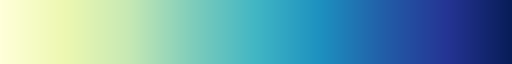

In [81]:
# Selecionando apenas as colunas de string de 2014 a 2024
# columns_to_update = [str(year) for year in range(2014, 2025)]

# df_results_subs[columns_to_update] = df_results_subs[columns_to_update].applymap(
#     lambda x: 0 if isinstance(x, (int, float)) and x > 35000 else x)

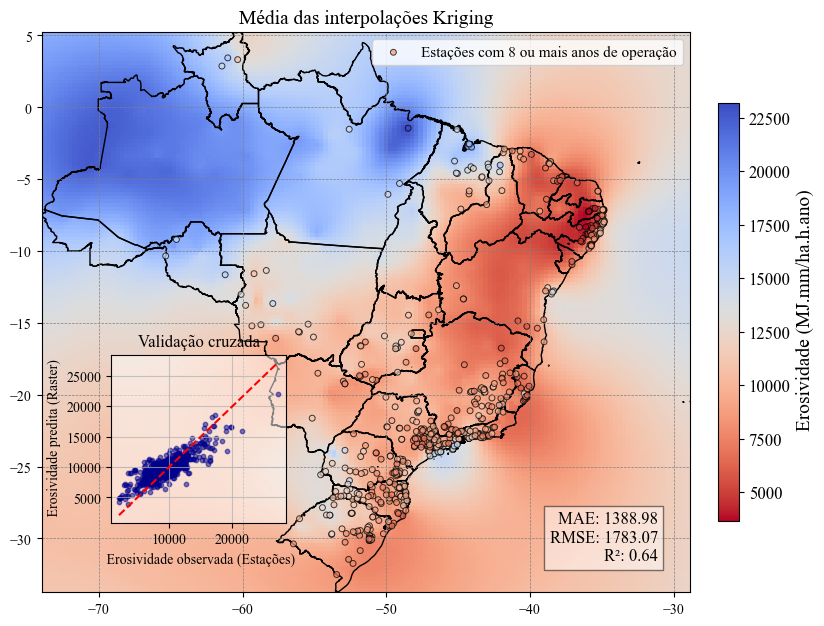

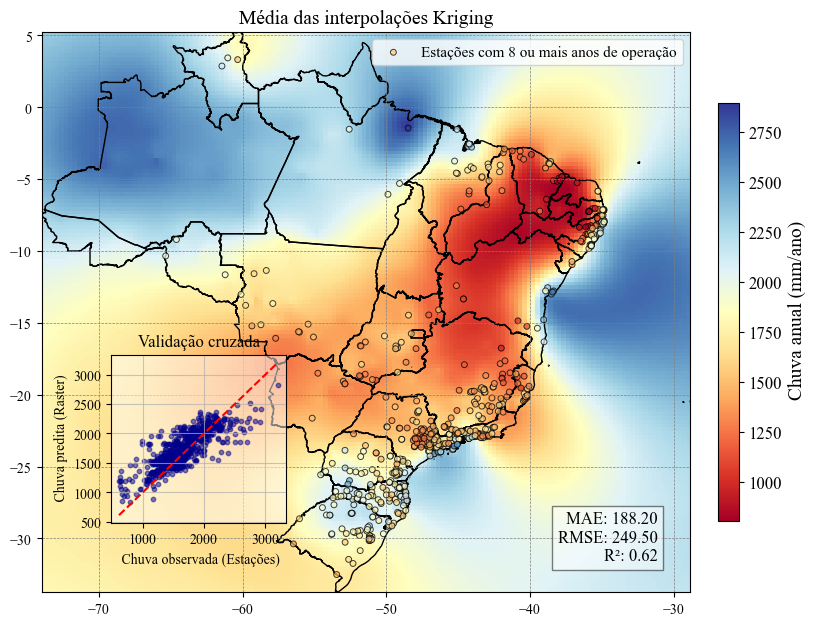

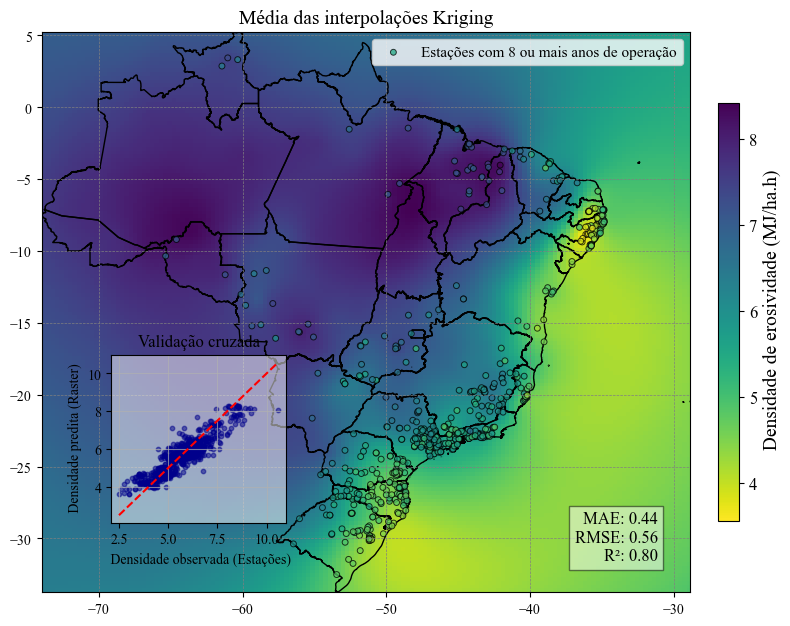

In [9]:
plt.rcParams.update({'font.family': 'Times New Roman'})


for k, mapa in enumerate(mapas):
    #DEFINIR BASE DE DADOS PARA COMPARAÇÃO - CROSS VALIDATION
    df_results_subs=pd.read_hdf(general_path +'/Results_Erosivity_filled.h5',key=mapa) # FILLED
    df_results_subs=df_results_subs[df_results_subs['sum']>=8] #anos de dados
    columns = [str(year) for year in range(2014, 2025)]
    
    #média dos valores sem contar o zero
    df_results_subs['mean'] = df_results_subs[columns].apply(lambda row: row[row != 0].mean(), axis=1)

    cmap = cmap_list[k]
    #OPEN IMAGE
    output_raster_path=os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')
    with rasterio.open(output_raster_path) as src:
        image = src.read(1)
    bounds = brasil_shapefile.total_bounds  # [minx, miny, maxx, maxy]
    minx, miny, maxx, maxy = bounds
    extent = [minx, maxx, miny, maxy]  
    
    
    
    point_values = []
    for _, row in df_results_subs.iterrows():
        lon, lat = row['long'], row['lat']
        y = math.ceil((lat + 33.75) * 150 / 39)
        x = math.ceil((lon + 74) * 150 / 45.2)
        point_values.append(image[y, x])
    
    mae = mean_absolute_error(df_results_subs['mean'], point_values)
    rmse = mean_squared_error(df_results_subs['mean'], point_values, squared=False)
    r2 = r2_score(df_results_subs['mean'], point_values)
    values=df_results_subs['mean']
    
    
    # Criando o mapa principal
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(image, extent=extent, origin='lower', cmap=cmap)
    brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    ax.set_title(f"Média das interpolações Kriging", fontsize=14)
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())  # Normaliza 
    scatter = ax.scatter(df_results_subs['long'],df_results_subs['lat'],c=values,cmap=cmap,s=18,edgecolor='black',linewidth=0.7,label='Estações com 8 ou mais anos de operação',alpha=0.75)
    
    img_plot = ax.imshow(image, extent=extent, origin='lower', cmap=cmap)
    cbar = plt.colorbar(img_plot, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(f" {unity[k]}", fontsize=14)
    ax.legend(fontsize=11)
    
    # Adicionando a caixa de texto no canto inferior direito
    stats_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}"
    ax.text(0.95, 0.05, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.5))
    
    # Adicionando o gráfico de validação cruzada no canto inferior esquerdo
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    inset_ax = inset_axes(ax, width="27%", height="30%", loc='lower left', borderpad=5)
    inset_ax.scatter(df_results_subs['mean'], point_values, s=10 ,color='darkblue', alpha=0.5)
    inset_ax.plot([min(df_results_subs['mean']), max(df_results_subs['mean'])],
                  [min(df_results_subs['mean']), max(df_results_subs['mean'])], color='red', linestyle='--')
    inset_ax.set_title("Validação cruzada", fontsize=12)
    inset_ax.set_xlabel(f" {unity[k].split(' ')[0]} observada (Estações)", fontsize=10)
    inset_ax.set_ylabel(f" {unity[k].split(' ')[0]} predita (Raster)", fontsize=10)
    inset_ax.tick_params(axis='both', which='major', labelsize=10)
    inset_ax.grid(True, alpha=0.7)
    inset_ax.patch.set_alpha(0.5)  # Fundo transparente do gráfico
    
    # Salvando e exibindo
    plt.savefig(os.path.join(general_path, '2 - Result_images', f'map_EVALUATION_{mapa}.png'), dpi=300, bbox_inches='tight')
    plt.show()


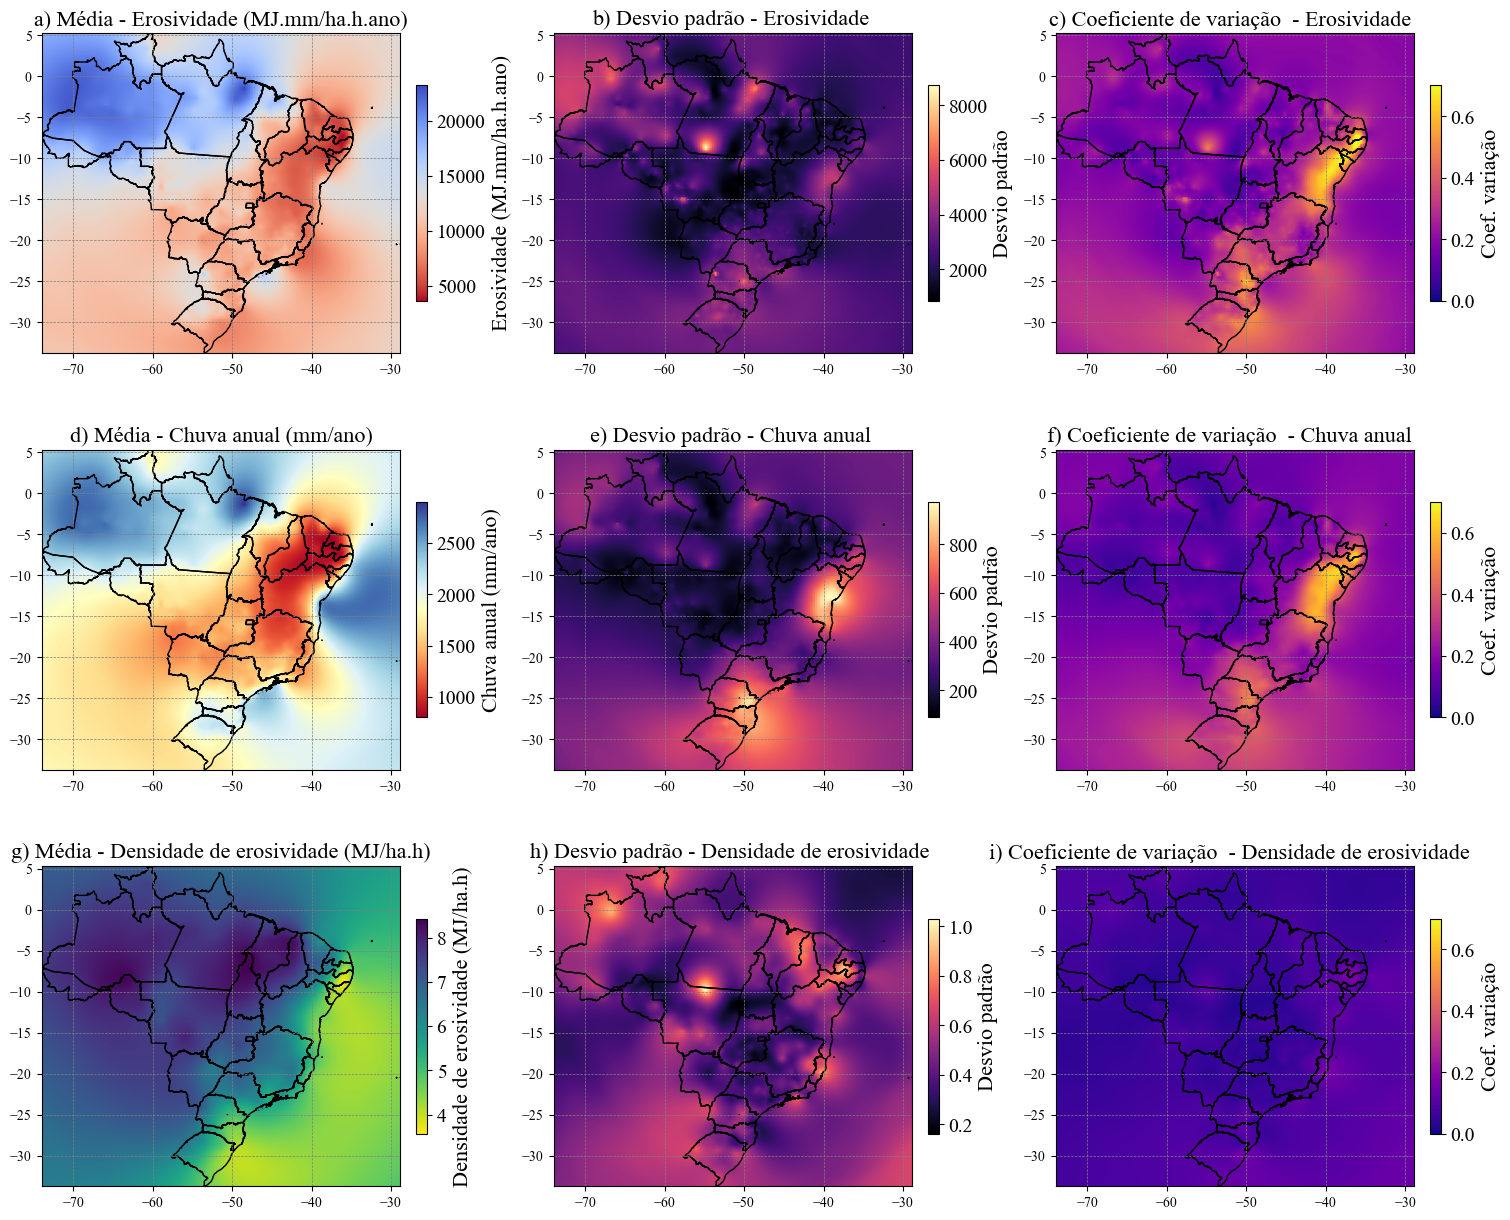

In [8]:


# Definindo a fonte global para Times New Roman
plt.rcParams.update({'font.family': 'Times New Roman'})

# Lista de mapas e unidades
mapas = ['EI_30', 'rain', 'E_D']
unity = ['Erosividade (MJ.mm/ha.h.ano)', 'Chuva anual (mm/ano)', 'Densidade de erosividade (MJ/ha.h)']

# Criar uma figura com 3 linhas e 3 colunas
fig, axes = plt.subplots(3, 3, figsize=(15, 12.5), constrained_layout=True)



for i, mapa in enumerate(mapas):
    output_std_dev_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_std_dev_2014_2024.tif')
    output_mean_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')
    
    with rasterio.open(output_mean_path) as src_mean, rasterio.open(output_std_dev_path) as src_std:
        image_mean = src_mean.read(1)
        image_std = src_std.read(1)
        image_c_v = image_std / image_mean
    
    bounds = brasil_shapefile.total_bounds
    minx, miny, maxx, maxy = bounds
    extent = [minx, maxx, miny, maxy]

    # Mapas para cada linha
    ax_mean, ax_std, ax_cv = axes.flatten()[i*3:i*3+3]  # Ajustando para pegar a ordem correta de subplots
    
    # Mapa de média

    img_plot_mean = ax_mean.imshow(image_mean, extent=extent, origin='lower', cmap=cmap_list[i])
    brasil_shapefile.plot(ax=ax_mean, facecolor="none", edgecolor="black", linewidth=1)
    ax_mean.set_title(f'{letra[i*3]}) Média - {unity[i]}', fontsize=16)  # Título com letra e aumento de fonte
    ax_mean.grid(color='gray', linestyle='--', linewidth=0.5)
    cbar_mean = plt.colorbar(img_plot_mean, ax=ax_mean, orientation='vertical', fraction=0.03, pad=0.04)
    cbar_mean.ax.tick_params(labelsize=14)
    cbar_mean.set_label(f'{unity[i]}', fontsize=16)

    # Mapa de desvio padrão
    img_plot_std = ax_std.imshow(image_std, extent=extent, origin='lower', cmap='magma')
    brasil_shapefile.plot(ax=ax_std, facecolor="none", edgecolor="black", linewidth=1)
    ax_std.set_title(f'{letra[i*3+1]}) Desvio padrão - {unity[i].split('(')[0]}', fontsize=16)  # Título com letra e aumento de fonte
    ax_std.grid(color='gray', linestyle='--', linewidth=0.5)
    cbar_std = plt.colorbar(img_plot_std, ax=ax_std, orientation='vertical', fraction=0.03, pad=0.04)
    cbar_std.ax.tick_params(labelsize=14)
    cbar_std.set_label('Desvio padrão', fontsize=16)
    
    # Mapa do coeficiente de variação
    img_plot_cv = ax_cv.imshow(image_c_v, extent=extent, origin='lower', cmap='plasma', vmin=0, vmax=0.7)
    brasil_shapefile.plot(ax=ax_cv, facecolor="none", edgecolor="black", linewidth=1)
    ax_cv.set_title(f'{letra[i*3+2]}) Coeficiente de variação  - {unity[i].split('(')[0]} ', fontsize=16)  # Título com letra e aumento de fonte
    ax_cv.grid(color='gray', linestyle='--', linewidth=0.5)
    cbar_cv = plt.colorbar(img_plot_cv, ax=ax_cv, orientation='vertical', fraction=0.03, pad=0.04)
    cbar_cv.ax.tick_params(labelsize=14)
    cbar_cv.set_label('Coef. variação', fontsize=16)

# Salvar e exibir o gráfico
plt.savefig(os.path.join(general_path, '2 - Result_images', 'map_Media_Desvio.png'), dpi=300, bbox_inches='tight')
plt.show()





<Figure size 1000x800 with 0 Axes>

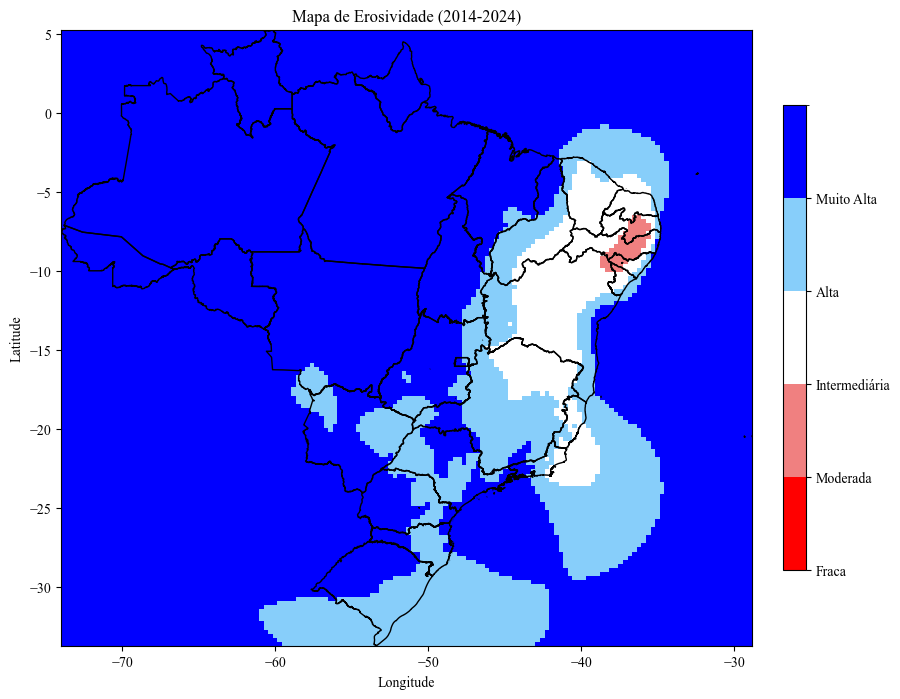

In [61]:
bounds = brasil_shapefile.total_bounds
minx, miny, maxx, maxy = bounds
extent = [minx, maxx, miny, maxy]
mapa = 'EI_30'
output_mean_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')

# Carrega a imagem (array) a partir do arquivo raster
with rasterio.open(output_mean_path) as src_mean:
    image_mean = src_mean.read(1)

image_mean = np.nan_to_num(image_mean, nan=0, posinf=0, neginf=0)

bins = [0.1, 2452, 4905, 7357, 9810, 60000]

norm = mcolors.BoundaryNorm(bins, ncolors=5)

cmap = mcolors.ListedColormap(['red', 'lightcoral', 'white', 'lightskyblue', 'blue'])

plt.figure(figsize=(10, 8))
plt.figure(figsize=(10, 8))

img=plt.imshow(image_mean, cmap=cmap, norm=norm,extent=extent,  origin='lower',alpha=1)
brasil_shapefile.plot(ax=plt.gca(), facecolor="none", edgecolor="black", linewidth=1)
cbar = plt.colorbar(img, ticks=bins[:-1],fraction=0.03, pad=0.04)
cbar.ax.set_yticklabels(['Fraca', 'Moderada', 'Intermediária', 'Alta', 'Muito Alta'])
plt.title("Mapa de Erosividade (2014-2024)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig(os.path.join(general_path, '2 - Result_images', 'map_classificação.png'), dpi=300, bbox_inches='tight')
plt.show()



In [81]:
df

Erosividade (R)     Nível de Erosividade  Percentual Observado (%)
0         R ≤ 2452        Erosividade Fraca                       0.0
1  2452 < R ≤ 4905        Erosividade Média                       0.4
2  4905 < R ≤ 7357  Erosividade Média-Forte                       4.9
3  7357 < R ≤ 9810        Erosividade Forte                      14.8
4         9810 < R  Erosividade Muito Forte                      79.9

   Erosividade (R)     Nível de Erosividade  Percentual Observado (%)
0         R ≤ 2452        Erosividade Fraca                       0.0
1  2452 < R ≤ 4905        Erosividade Média                       0.4
2  4905 < R ≤ 7357  Erosividade Média-Forte                       4.9
3  7357 < R ≤ 9810        Erosividade Forte                      14.8
4         9810 < R  Erosividade Muito Forte                      79.9


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Windows\\OneDrive\\Documentos\\mestrado\\DISSERTAÇÃO\\scripts\\general_path\\2 - Result_images\\map_classificação 2.png'

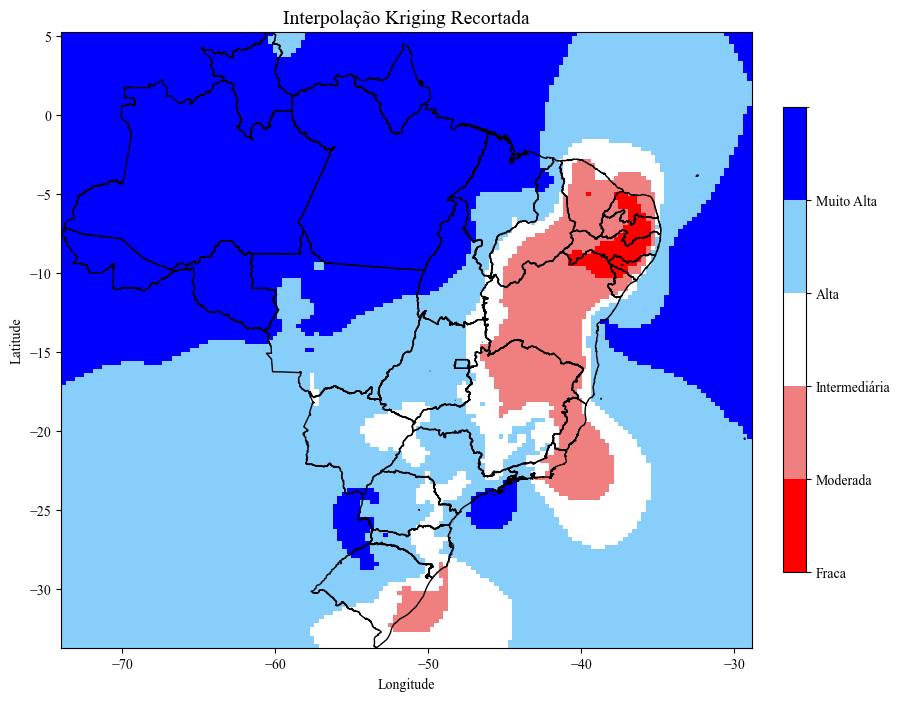

In [69]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import os

# Abrir o raster recortado
with rasterio.open(output_mean_path) as src:
    image_cropped = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Definir os intervalos de erosividade e rótulos
bins = [0, 2452, 4905, 7357, 9810, np.inf]
labels = [
    "Erosividade Fraca",
    "Erosividade Média",
    "Erosividade Média-Forte",
    "Erosividade Forte",
    "Erosividade Muito Forte"
]

# Contar os pixels em cada intervalo
hist, _ = np.histogram(image_cropped, bins=bins)
total_pixels = np.sum(hist)
percentages = (hist / total_pixels) * 100

# Criar DataFrame com os resultados
df = pd.DataFrame({
    "Erosividade (R)": ["R ≤ 2452", "2452 < R ≤ 4905", "4905 < R ≤ 7357", "7357 < R ≤ 9810", "9810 < R"],
    "Nível de Erosividade": labels,
    "Percentual Observado (%)": np.round(percentages, 1)
})

print(df)

# Definir o normalizador e o cmap
bins = [0.1, 5452, 7905, 9357, 12810, 60000]
norm = mcolors.BoundaryNorm(bins, ncolors=5)
cmap = mcolors.ListedColormap(['red', 'lightcoral', 'white', 'lightskyblue', 'blue'])


# Plotar a imagem
fig, ax = plt.subplots(figsize=(10, 8))
img = ax.imshow(image_cropped, cmap=cmap, norm=norm, extent=extent, origin='lower', alpha=1)

# Plotar o shapefile do Brasil
brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

# Adicionar a barra de cores
cbar = plt.colorbar(img, ticks=bins[:-1], fraction=0.03, pad=0.04)
cbar.ax.set_yticklabels(['Fraca', 'Moderada', 'Intermediária', 'Alta', 'Muito Alta'])

# Configurações do gráfico
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Interpolação Kriging Recortada", fontsize=14)

# Salvar o gráfico
output_path = os.path.join("general_path", "2 - Result_images", "map_classificação 2.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()


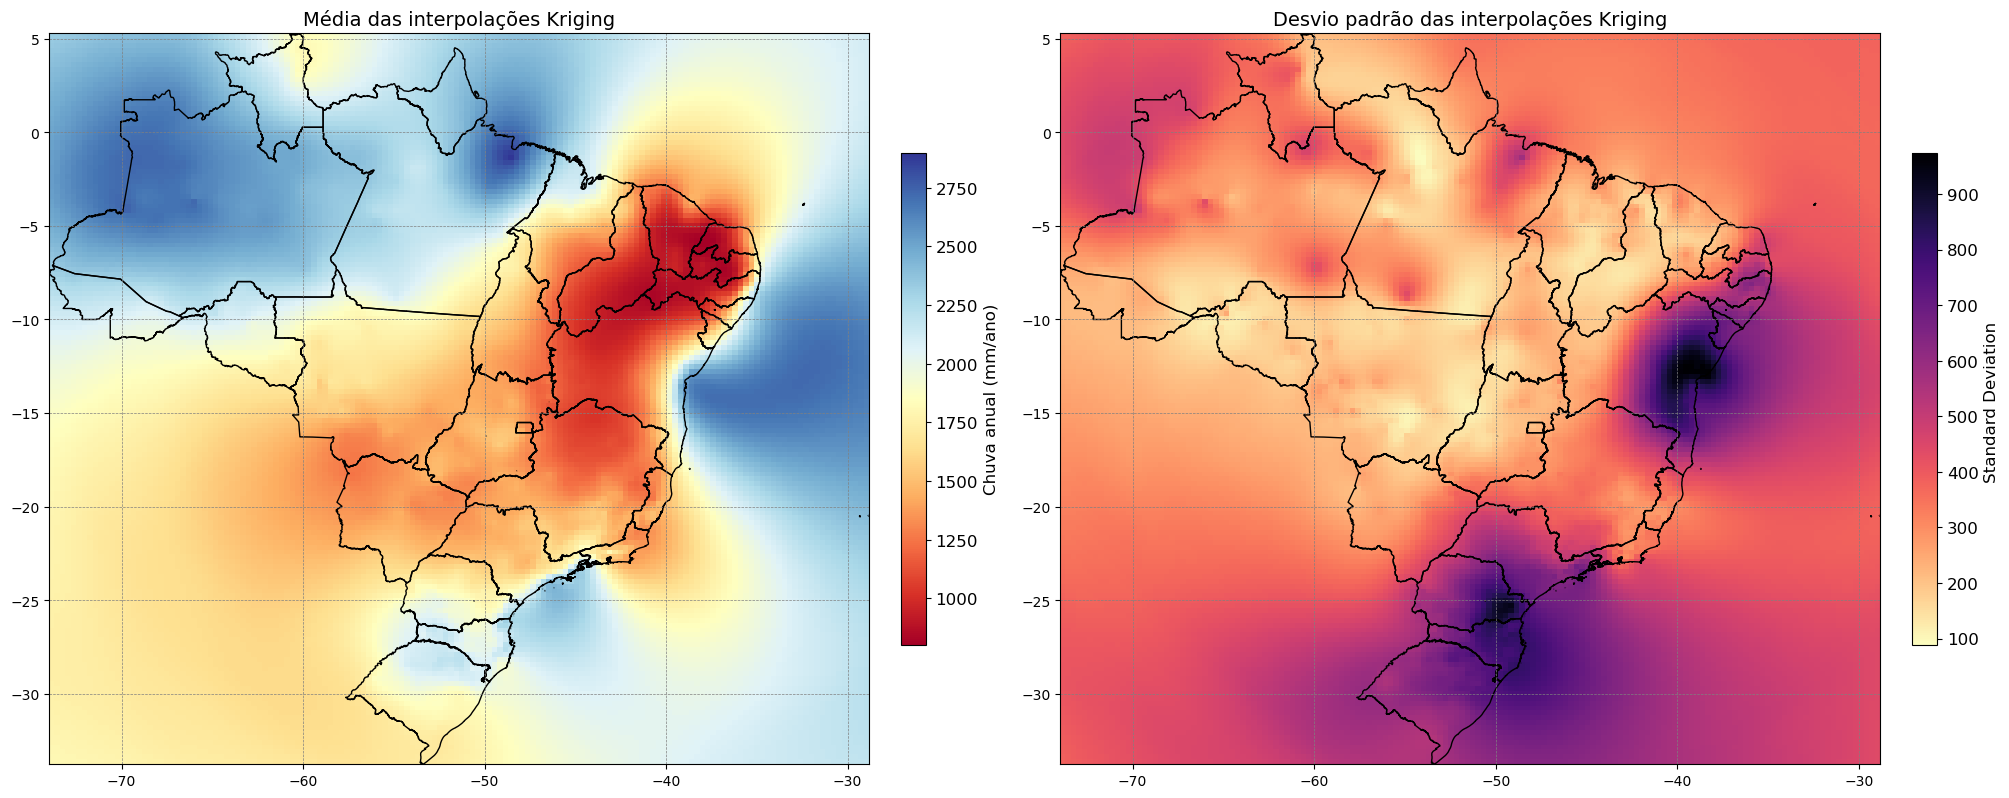

In [90]:
mapas =['EI_30','rain','E_D']
unity=['Erosividade (MJ.mm/ha.h.ano)','Chuva anual (mm/ano)','Densidade de erosividade (MJ/ha.h)']
for mapa in mapas
    output_std_dev_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_std_dev_2014_2024.tif')
    output_mean_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')
    with rasterio.open(output_mean_path) as src_mean, rasterio.open(output_std_dev_path) as src_std:
        image_mean = src_mean.read(1)
        image_std = src_std.read(1)
    
    
    bounds = brasil_shapefile.total_bounds
    minx, miny, maxx, maxy = bounds
    extent = [minx, maxx, miny, maxy]
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)
    
    for ax, image, title, cmap, cbar_label in zip(
        axes, 
        [image_mean, image_std], 
        ["a) ", "Desvio padrão das interpolações Kriging"], 
        [cmap, plt.cm.magma.reversed()], 
        [f"{unity}", "Coeficiente de variação "]
    ):
        img_plot = ax.imshow(image, extent=extent, origin='lower', cmap=cmap)
        brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
        ax.grid(color='gray', linestyle='--', linewidth=0.5)
        ax.set_title(title, fontsize=16)
        cbar = plt.colorbar(img_plot, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label(cbar_label, fontsize=14)
    plt.savefig(os.path.join(general_path, '2 - Result_images', 'map_Média_Desvio_rain.png'), dpi=300, bbox_inches='tight')
    plt.show()


In [23]:

# Extract the necessary columns
latitude = df_data['lat'].values
longitude = df_data['long'].values
aqi_value = df_data[str(year)].values
# Define the grid for interpolation
bounds = brasil_shapefile.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds
gridx = np.linspace(minx , maxx , 150)
gridy = np.linspace(miny, maxy , 150)

## Ordinary Kriging

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: 71943707.99522984
Full Sill: 114103833.90526006
Range: 7.609283067277492
Nugget: 42160125.91003021 



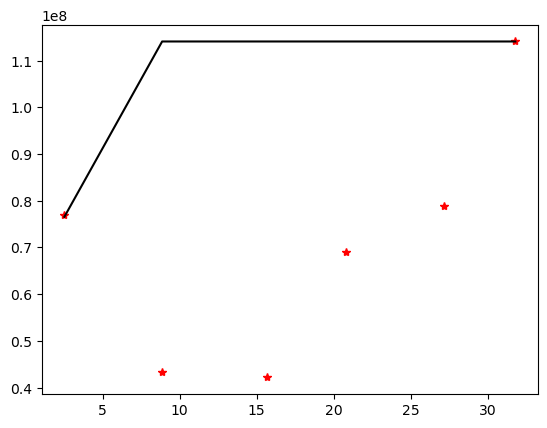

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [24]:


# Perform Ordinary Kriging using the spherical variogram model
OK = OrdinaryKriging(longitude, 
                     latitude, 
                     aqi_value, 
                     variogram_model='spherical', 
                     coordinates_type='geographic', 
                     verbose=True, 
                     enable_plotting=True)
z_interp, ss = OK.execute('grid', gridx, gridy)

## Create overlay image of kriging interpolated values

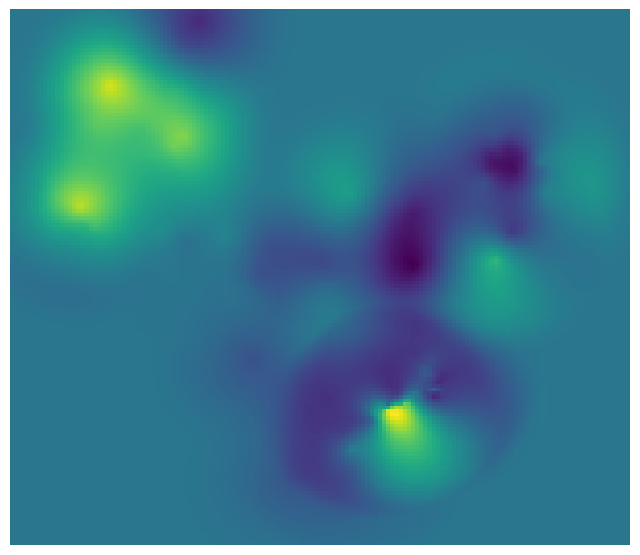

In [25]:
year = 2014
df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
df_data=df_data[['long','lat',str(year),'state','gauge_code']].replace(0, np.nan).dropna().reset_index(drop=True)
df_data
latitude = df_data['lat'].values
longitude = df_data['long'].values
aqi_value = df_data[str(year)].values

# Perform Ordinary Kriging using the spherical variogram model
OK = OrdinaryKriging(longitude, 
                     latitude, 
                     aqi_value, 
                     variogram_model='spherical', 
                     coordinates_type='geographic', 
                     verbose=True, 
                     enable_plotting=True)
z_interp, ss = OK.execute('grid', gridx, gridy)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the interpolation results
cax = ax.imshow(z_interp, 
                extent=[gridx.min(), 
                        gridx.max(), 
                        gridy.min(), 
                        gridy.max()], 
                origin='lower', 
                cmap='viridis', 
                alpha=1)
ax.axis('off')

# Save the image
fig.savefig('kriging_interpolation.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

# Load the image with PIL
image = Image.open('kriging_interpolation.png')
fig          

## Create base map with overlayed interpolated data

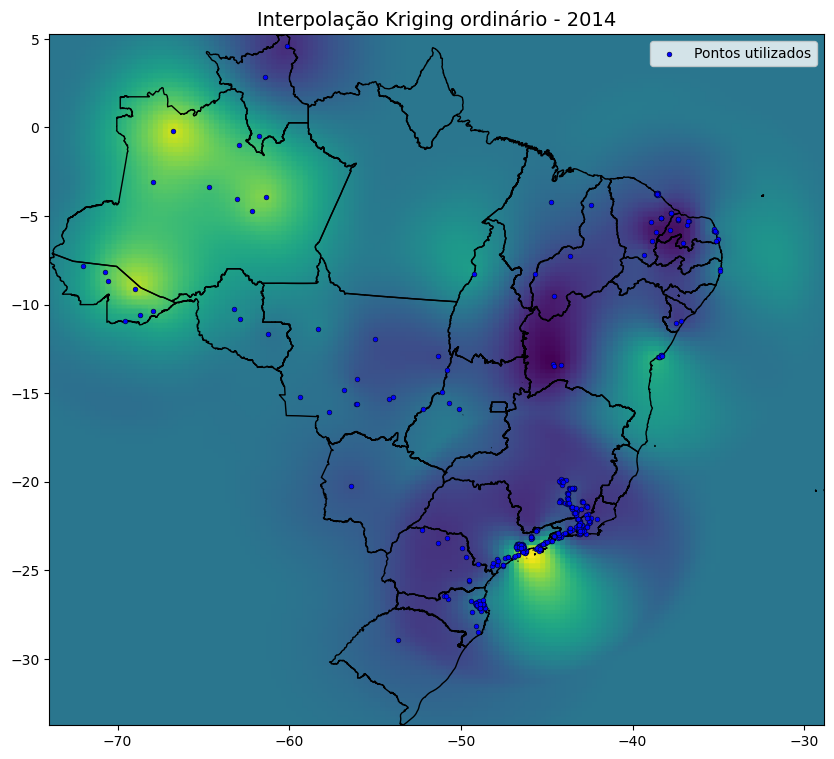

In [29]:



# Abrir a imagem interpolada recortada
image_path = "kriging_interpolation.png"
image = Image.open(image_path)

# Configurar os limites do recorte na escala geográfica
bounds = brasil_shapefile.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds
extent = [minx, maxx, miny, maxy]  # Extensão da área de interesse

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Exibir a imagem interpolada como plano de fundo
ax.imshow(image, extent=extent, origin='upper', cmap='viridis')

# Plotar o shapefile do Brasil
brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

# Plotar os pontos utilizados
ax.scatter(longitude, latitude, color="blue", label="Pontos utilizados", zorder=3,marker='o',s=12,edgecolor="black",linewidth=0.35 )


# Configurar título e legenda
ax.set_title(f"Interpolação Kriging ordinário - {}", fontsize=14)
ax.legend()

# Salvar a figura
plt.savefig(f"Kriging_map_{year}.png", dpi=300, bbox_inches='tight')

# Mostrar a figura
plt.show()

TypeError: Invalid shape (1, 150, 150) for image data

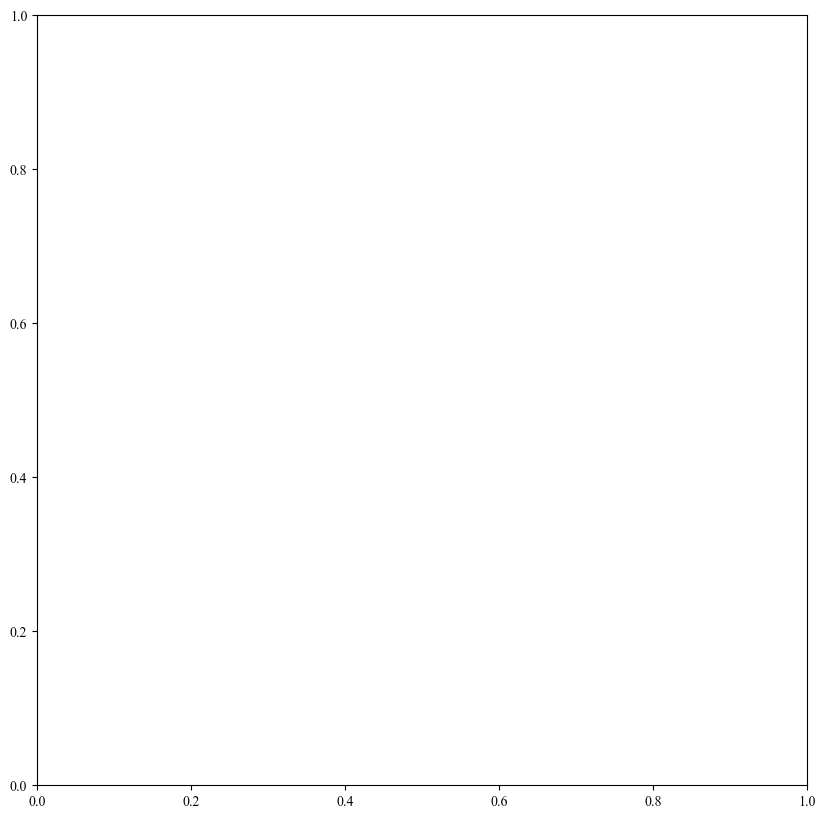

In [66]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from PIL import Image
with rasterio.open(output_mean_path) as src_mean:
    z_interp = src_mean.read(1)

# Salvar a interpolação como um GeoTIFF
with rasterio.open(
    output_mean_path,
    "w",
    driver="GTiff",
    height=z_interp.shape[0],
    width=z_interp.shape[1],
    count=1,
    dtype=z_interp.dtype,
    crs="EPSG:4326",  # Certifique-se de usar a projeção correta
    transform=rasterio.transform.from_bounds(minx, miny, maxx, maxy, z_interp.shape[1], z_interp.shape[0]),
) as dst:
    dst.write(z_interp, 1)


# Recortar o GeoTIFF com base no shapefile
with rasterio.open(output_mean_path) as src:
    out_image, out_transform = mask(src, brasil_shapefile.geometry, crop=True)
    out_meta = src.meta

# Atualizar metadados para o novo arquivo recortado
out_meta.update(
    {"driver": "GTiff", "height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform}
)

# Salvar o GeoTIFF recortado
with rasterio.open("interpolation_cropped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# Reabrir e plotar a imagem recortada
with rasterio.open("interpolation_cropped.tif") as src:
    image_cropped = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(out_image, extent=extent, origin="upper", cmap="magma")
brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
ax.set_title("Interpolação Kriging Recortada", fontsize=14)
ax.legend()
plt.show()


   Erosividade (R)     Nível de Erosividade  Percentual Observado (%)
0         R ≤ 2452        Erosividade Fraca                      59.7
1  2452 < R ≤ 4905        Erosividade Média                       0.0
2  4905 < R ≤ 7357  Erosividade Média-Forte                       3.4
3  7357 < R ≤ 9810        Erosividade Forte                       8.1
4         9810 < R  Erosividade Muito Forte                      28.8


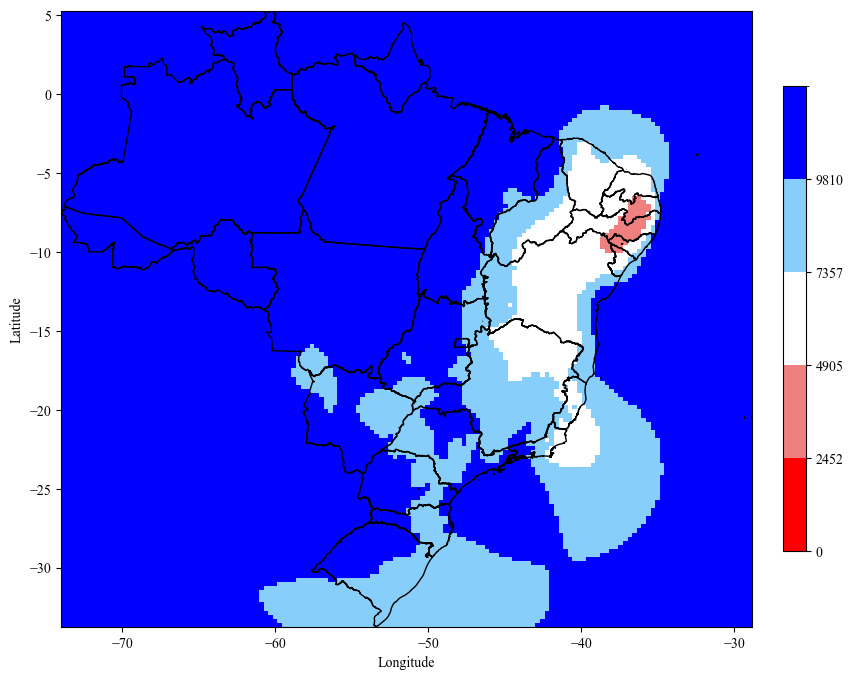

In [82]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt

# Abrir o raster recortado
with rasterio.open("interpolation_cropped.tif") as src:
    image_cropped = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Definir os intervalos de erosividade e rótulos
bins = [0, 2452, 4905, 7357, 9810, np.inf]
labels = [
    "Erosividade Fraca",
    "Erosividade Média",
    "Erosividade Média-Forte",
    "Erosividade Forte",
    "Erosividade Muito Forte"
]

# Contar os pixels em cada intervalo
hist, _ = np.histogram(image_cropped, bins=bins)
total_pixels = np.sum(hist)
percentages = (hist / total_pixels) * 100

# Criar DataFrame com os resultados
df = pd.DataFrame({
    "Erosividade (R)": ["R ≤ 2452", "2452 < R ≤ 4905", "4905 < R ≤ 7357", "7357 < R ≤ 9810", "9810 < R"],
    "Nível de Erosividade": labels,
    "Percentual Observado (%)": np.round(percentages, 1)
})

print(df)
bins = [0.1, 2452, 4905, 7357, 9810, 60000]

norm = mcolors.BoundaryNorm(bins, ncolors=5)

cmap = mcolors.ListedColormap(['red', 'lightcoral', 'white', 'lightskyblue', 'blue'])

plt.figure(figsize=(10, 8))


img=plt.imshow(image_mean, cmap=cmap, norm=norm,extent=extent,  origin='lower',alpha=1)
brasil_shapefile.plot(ax=plt.gca(), facecolor="none", edgecolor="black", linewidth=1)
cbar = plt.colorbar(img, ticks=bins[:-1],fraction=0.03, pad=0.04)

plt.xlabel("Longitude")
plt.ylabel("Latitude")

brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
ax.set_title("Interpolação Kriging Recortada", fontsize=14)
plt.savefig(os.path.join(general_path, '2 - Result_images', 'map_classificação.png'), dpi=300, bbox_inches='tight')




plt.show()


In [54]:
df

Erosividade (R)     Nível de Erosividade  Percentual Observado (%)
0         R ≤ 2452        Erosividade Fraca                      59.7
1  2452 < R ≤ 4905        Erosividade Média                       0.0
2  4905 < R ≤ 7357  Erosividade Média-Forte                       3.4
3  7357 < R ≤ 9810        Erosividade Forte                       8.1
4         9810 < R  Erosividade Muito Forte                      28.8


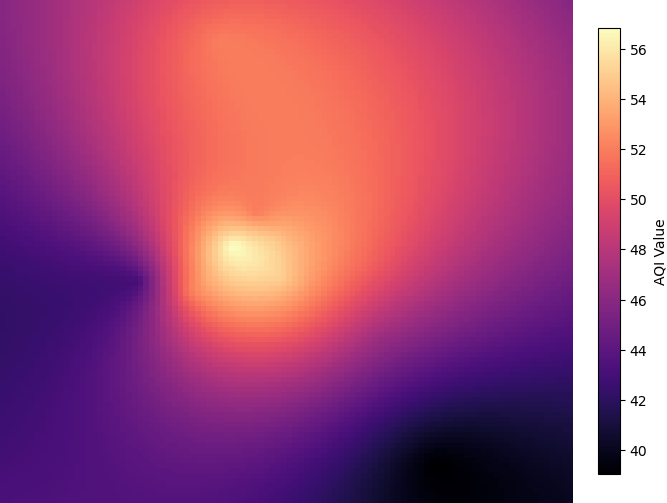

In [15]:
import folium
from folium.raster_layers import ImageOverlay

# Create a base map centered on Houston
m = folium.Map(location=[29.76, -95.37], zoom_start=10)

# Define the bounds where the image will be placed
bounds = [[gridy.min(), gridx.min()], [gridy.max(), gridx.max()]]

# Add the image overlay
image_overlay = ImageOverlay(
    image='kriging_interpolation.png',
    bounds=bounds,
    opacity=.7,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

image_overlay.add_to(m)

# Add points for the measuring stations
for lat, lon in zip(latitude, longitude):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1
    ).add_to(m)

# Save the map to an HTML file
m.save('houston_kriging_map_with_mesh.html')

# Display the map
m
